In [8]:
import pandas as pd
df = pd.read_csv('HAM10000_metadata.csv')
print(df.columns)
print(df['dx'].isna().sum())

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')
0


In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load data
data_path = 'HAM10000_metadata.csv'
image_dir = 'segmented_images/'

df = pd.read_csv(data_path)
df['image_path'] = image_dir + df['image_id'] + '.jpg'

# Split data into training and validation sets
train_df = df[df['dx'].str.strip().isin(['nv', 'mel', 'bkl', 'df', 'vasc', 'bcc', 'akiec'])].sample(frac=0.8, random_state=42)
val_df = df[df['dx'].str.strip().isin(['nv', 'mel', 'bkl', 'df', 'vasc', 'bcc', 'akiec'])].sample(frac=0.8, random_state=42)


# Define image data generators
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2)

num_classes = len(train_df['dx'].unique())
print(len(val_df['dx'].unique()))
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    num_classes=num_classes)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    num_classes=num_classes)

# Define model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=20,
                    callbacks=[early_stop])


7
Found 6410 validated image filenames belonging to 7 classes.
Found 6410 validated image filenames belonging to 7 classes.
Epoch 1/20
201/201 [==============================] - 619s 3s/step - loss: 1.0971 - accuracy: 0.6688 - val_loss: 0.9518 - val_accuracy: 0.6819
Epoch 2/20
201/201 [==============================] - 570s 3s/step - loss: 0.9913 - accuracy: 0.6764 - val_loss: 0.9126 - val_accuracy: 0.6925
Epoch 3/20
201/201 [==============================] - 547s 3s/step - loss: 0.9490 - accuracy: 0.6867 - val_loss: 0.8723 - val_accuracy: 0.7014
Epoch 4/20
201/201 [==============================] - 591s 3s/step - loss: 0.9079 - accuracy: 0.7006 - val_loss: 0.8056 - val_accuracy: 0.7225
Epoch 5/20
201/201 [==============================] - 545s 3s/step - loss: 0.8419 - accuracy: 0.7170 - val_loss: 0.6791 - val_accuracy: 0.7844
Epoch 6/20
201/201 [==============================] - 521s 3s/step - loss: 0.7751 - accuracy: 0.7415 - val_loss: 0.6003 - val_accuracy: 0.7998
Epoch 7/20
201/201

Saving the model

uploading the image and pridicting

In [39]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('ISIC_0024306.jpg')

# Preprocess the image (resize and rescale pixel values)
img = cv2.resize(img, (224, 224))
img = img.astype('float32') / 255.0

# Add a batch dimension to match the shape expected by the model
img = np.expand_dims(img, axis=0)

# Make predictions using the trained model
predictions = model.predict(img)

# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=-1)

# Map the class index to class name
class_names = ['nv', 'mel', 'bkl', 'df', 'vasc', 'bcc', 'akiec', 'other']
predicted_class_name = class_names[predicted_class[0]]

# Print the predicted class name
print(predicted_class_name)


1/1 [==============================] - 0s 66ms/step
bcc


upload and predicting part 2

In [40]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('ISIC_0024306.jpg')

# Preprocess the image (resize and rescale pixel values)
img = cv2.resize(img, (224, 224))
img = img.astype('float32') / 255.0

# Add a batch dimension to match the shape expected by the model
img = np.expand_dims(img, axis=0)

# Make predictions using the trained model
predictions = model.predict(img)

# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=-1)

# Map the class index to class name
class_names = ['nv', 'mel', 'bkl', 'df', 'vasc', 'bcc', 'akiec', 'other']
predicted_class_name = class_names[predicted_class[0]]

# Print the predicted class name and percentage for each class
for i in range(len(class_names)):
    class_prob = predictions[0][i] * 100
    print(f"{class_names[i]}: {class_prob:.2f}%")



1/1 [==============================] - 0s 60ms/step
nv: 0.00%
mel: 0.15%
bkl: 0.21%
df: 0.00%
vasc: 5.32%
bcc: 94.27%
akiec: 0.06%


IndexError: index 7 is out of bounds for axis 0 with size 7

upload and predict part 3 with bar chart

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from flask import Flask
 
# Flask constructor takes the name of
# current module (__name__) as argument.
app = Flask(__name__)
 
# The route() function of the Flask class is a decorator,
# which tells the application which URL should call
# the associated function.
@app.route('/')
# ‘/’ URL is bound with hello_world() function.
def hello_world():

    # Load the image

    return "hhhh"
    img = cv2.imread(r'segmented_images\ISIC_0024609.jpg')

    # Preprocess the image (resize and rescale pixel values)
    img = cv2.resize(img, (224, 224))
    img = img.astype('float32') / 255.0

    # Add a batch dimension to match the shape expected by the model
    img = np.expand_dims(img, axis=0)

    # Make predictions using the trained model
    mod = load_model("model_classification.h5")
    predictions = mod.predict(img)
    print(predictions)
    # Get the class probabilities
    class_probabilities = predictions[0]

    # Map the class probabilities to class names
    class_names = ['nv', 'mel', 'bkl', 'df', 'vasc', 'bcc', 'akiec']

    # Print the class probabilities as percentages
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {class_probabilities[i]*100:.2f}%")

    # Create a bar chart showing the class probabilities
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
    plt.bar(class_names, class_probabilities, color=colors)
    plt.title("Class Probabilities")
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.show()
    
app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


In [1]:
pip install Flask


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


1/1 [==============================] - 1s 529ms/step
[[1.5333416e-10 6.9725611e-06 8.2526909e-05 2.2517183e-04 3.3307909e-03
  9.9635458e-01 1.6564062e-08]]
nv: 0.00%
mel: 0.00%
bkl: 0.01%
df: 0.02%
vasc: 0.33%
bcc: 99.64%
akiec: 0.00%


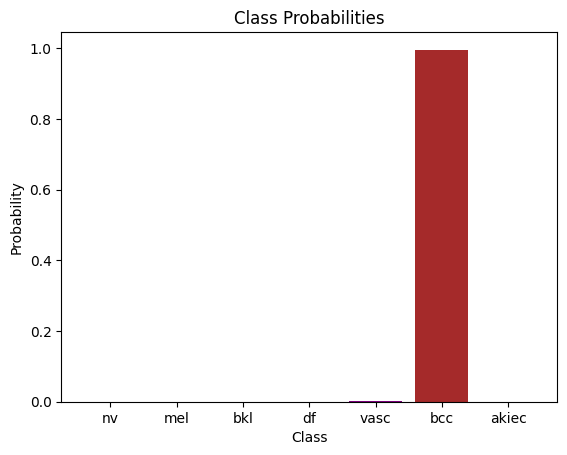

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ‘/’ URL is bound with hello_world() function.


# Load the image
img = cv2.imread(r'segmented_images\ISIC_0024609.jpg')

# Preprocess the image (resize and rescale pixel values)
img = cv2.resize(img, (224, 224))
img = img.astype('float32') / 255.0

# Add a batch dimension to match the shape expected by the model
img = np.expand_dims(img, axis=0)

# Make predictions using the trained model
mod = load_model("model_classification.h5")
predictions = mod.predict(img)
print(predictions)
# Get the class probabilities
class_probabilities = predictions[0]

# Map the class probabilities to class names
class_names = ['nv', 'mel', 'bkl', 'df', 'vasc', 'bcc', 'akiec']

# Print the class probabilities as percentages
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_probabilities[i]*100:.2f}%")

# Create a bar chart showing the class probabilities
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
plt.bar(class_names, class_probabilities, color=colors)
plt.title("Class Probabilities")
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()
